In [126]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.signal import get_window

from util import my_windowing

%matplotlib widget


Download the file Exercise6.zip from Moodle which contains two speech signals which are corrupted once by white noise and once by babble noise. For both files the signal-to-noise ratio (SNR) is 10 dB.

In [221]:
class WaveFile:
    filename: str
    y: np.ndarray
    sr: int
    num_samples: int

    def __init__(self, filename: str) -> None:
        self.filename = filename
        self.y, self.sr = librosa.load(filename, sr=None)

    def play(self):
         sd.play(self.y, self.sr)

    def _split_frames(self, frame_length, frame_shift):
        self.m_frames, self.v_time = my_windowing(
            self.y,
            self.sr,
            frame_length,
            frame_shift
        )
        self.num_frames = self.m_frames.shape[0]
        self.samples_per_frame = self.m_frames.shape[1]
    
    def compute_stft(self, frame_length: int, frame_shift: int, window: str):
        self._split_frames(frame_length, frame_shift)
        
        v_analysis_window = np.sqrt(get_window(window=window, Nx=self.samples_per_frame, fftbins=True))

        # create frequency vector
        v_freq = self.sr * (np.arange(self.samples_per_frame / 2 + 1) / self.samples_per_frame)

        # calculate DFT
        _m_frames = self.m_frames
        _m_frames *= v_analysis_window
        dft = np.fft.fft(_m_frames, axis=1)

        # drop upper half of the spectrum while keeping the nyquist frequency in the middle
        num_freq_bins = dft.shape[1]
        if num_freq_bins % 2 == 0: # even 
            dft = dft[:, : num_freq_bins // 2 + 1]
        else: # odd
            dft = dft[:, : (num_freq_bins + 1) // 2]
        m_stft = dft
        
        np.testing.assert_array_almost_equal(m_stft, np.fft.rfft(_m_frames, axis=1))
        
        self.m_stft = m_stft.T
        self.v_freq = v_freq

    def set_spp(self, m_spp: np.ndarray):
        self.m_spp = m_spp
    
    def set_psd(self, m_signal_psd:np.ndarray, m_noise_psd: np.ndarray):
        self.m_signal_psd = m_signal_psd
        self.m_noise_psd = m_noise_psd


speech_babble = WaveFile("SpeechBabble.wav")
speech_white = WaveFile("SpeechWhite.wav")

frame_length = 32
frame_shift = 16

speech_babble.compute_stft(frame_length, frame_shift, "hann")
speech_white.compute_stft(frame_length, frame_shift, "hann")

In [206]:
speech_babble.play()

In [207]:
speech_white.play()

**1 Noise Power Estimation**

In this part of the exercise, the noise power is estimated based on the speech presence probability. First, use
your functions from the second exercise to create the STFT of the noisy input signals. The frame length should
be 32 ms and the frame shift 16 ms. Use a √Hann-window as analysis window. From the STFT, compute the
periodograms and determine the noise PSD by performing the following steps for each frame.

1. Compute the posterior probability of speech presence
2. Avoid stagnations by smoo

- Signal-to-noise ratio (SNR): $\theta = 15 \ dB$

In [222]:
def compute_ssp(signal: WaveFile, snr: int):
    m_signal_psd = np.abs(signal.m_stft)**2
    num_frames = m_signal_psd.shape[0]
    num_bins = m_signal_psd.shape[1]
    
    m_spp = np.zeros((num_frames, num_bins))
    m_noise_psd = np.zeros((num_frames, num_bins+1))
    Q = np.zeros((num_frames, num_bins+1))

    # init noise periodogram
    m_noise_psd[:, 0] = np.abs(signal.m_stft[:, 0])**2

    # loop over frequency bins
    for i in range(m_signal_psd.shape[1]):
        m_spp[:, i] = (1 + (1 + snr) * np.exp(-(m_signal_psd[:, i] / m_noise_psd[:, i]) * (snr / (1 + snr))))**(-1)

        # calculate q for next frame
        Q[:, i+1] = 0.9 * Q[:, i] + 0.1 * m_spp[:, i]
        for j in range(Q.shape[0]):
            if Q[j, i+1] > 0.99:
                m_spp[j, i] = min(m_spp[j, i], 0.99)

        noise_periodogram = m_spp[:, i] * m_noise_psd[:, i] + (1 - m_spp[:, i]) * m_signal_psd[:, i]
        m_noise_psd[:, i+1] = 0.8 * m_noise_psd[:, i] + 0.2*noise_periodogram

    signal.set_spp(m_spp)
    signal.set_psd(m_signal_psd, m_noise_psd)

compute_ssp(speech_babble, 15)
compute_ssp(speech_white, 15)

**Questions**

1.1 In equation (1), (3) and (4) the noise power estimate from the previous frame, $\hat\sigma^2_n[k, \ell-1]$, is required. However, there is none available for the first frame $\ell=0$. The same problem occurs for the smoothed speech presence probability $Q[k,\ell]$ in (2).

a) What would be appropriate initializations for the first noise estimate $\hat\sigma^2_n[k, \ell-1]$ and the smoothed posterior probability $Q[k,\ell−1]$? Explain briefly why you chose your initialization method.

1.2 Plot the speech presence probability $P(H_1|Y[k,\ell])$ using `plt.imshow`.

a) Which values do you obtain for time-frequency points where speech is present?

b) What values do you get for time-frequency points where only noise is present?

c) If you compare the speech presence probability with the spectrogram of your input signal, can you see
similarities?

1.3 Plot the estimated noise PSD as a spectrogram using plt.imshow.

a) How well is the background noise estimated?

b) Can you observe errors (e. g. components that do not belong to the background noise)?

c) What would be the consequence of such errors?

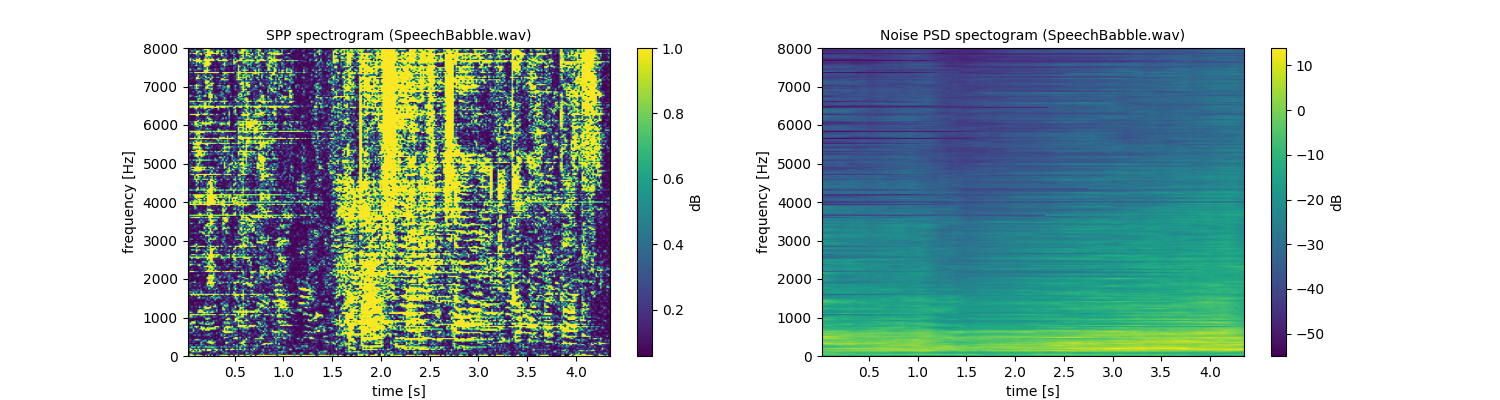

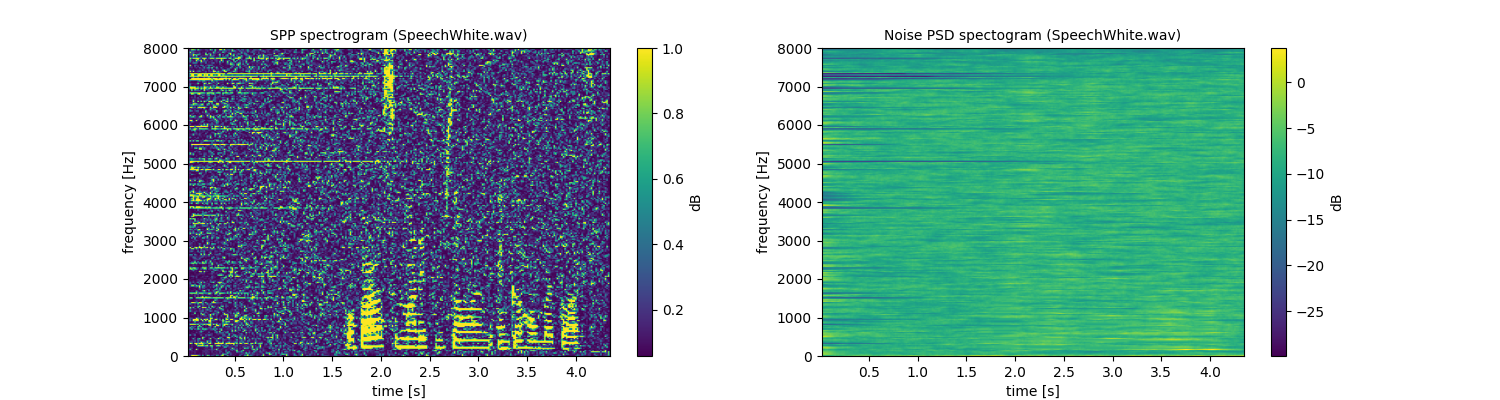

In [239]:
def plot_ssp_spectorgram(f: WaveFile):
    fig, axes = plt.subplots(1, 2, figsize=(15,4))
    axes = axes.flatten()
    
    ax = axes[0]
    ax.set_title(f"SPP spectrogram ({f.filename})", fontdict={"size": 10})
    ax.set_xlabel("time [s]")
    ax.set_ylabel("frequency [Hz]")
    im = ax.imshow(
        f.m_spp,
        extent=[f.v_time[0], f.v_time[-1], f.v_freq[0], f.v_freq[-1]],
        origin="lower",
        aspect="auto",
    )
    colorbar = fig.colorbar(im, orientation="vertical")
    colorbar.set_label("dB")

    ax = axes[1]
    ax.set_title(f"Noise PSD spectogram ({f.filename})", fontdict={"size": 10})
    ax.set_xlabel("time [s]")
    ax.set_ylabel("frequency [Hz]")
    im = ax.imshow(
        10*np.log10(f.m_noise_psd),
        extent=[f.v_time[0], f.v_time[-1], f.v_freq[0], f.v_freq[-1]],
        origin="lower",
        aspect="auto",
    )
    colorbar = fig.colorbar(im, orientation="vertical")
    colorbar.set_label("dB")

plot_ssp_spectorgram(speech_babble)
plot_ssp_spectorgram(speech_white)

**2 A priori SNR estimation and Wiener Filtering**

Perform the steps in equations (5) – (7) for every frame of your input signal and store all enhanced speech
spectra ˆS[k,`] in a matrix, e. g. m_enhanced_stft. (Look at sheet for the steps)

*Questions*

2.1 In equation (5), the issue from Section 1 occurs again. An initialization for ˆS[k,`] is required for the first
frame.

*What would be a reasonable choice in this case?*

2.2 Set α = 0.5 and Gmin = 0. Plot the magnitude spectrogram of the noisy speech signal and the enhanced
speech signal in dB and compare both. Make sure, that the color bar for both plots is the same. This can
be achieved by manually setting the vmin and vmax parameters of plt.imshow.

a) How does the clean spectrogram differ from the spectrogram of the noisy input signal?

b) Can you see artifacts in the spectrogram of the enhanced signal?

**3 Parameter tuning**

Use the compute_istft function to synthesize the enhanced speech signal. For this, employ the same frame shift
and FFT length as in Section 1. Further, use the √Hann-window also for the synthesis.

Listen to the noisy signal and the enhanced signal. For this you could use the play function from sounddevice.

*Questions*

3.1 Compare the noisy and the enhanced signal with each other.

a) How well is the background noise suppressed?

b) Can you hear any distortions of the speech signal in the enhanced signal?

c) What artifacts can you hear?

3.2 Vary α between 0 and 1 and listen to the synthesized signals.

a) What differences can you perceive?

b) How do the artifacts, speech signal and noise suppression change?

c) What is your favorite setting? Explain why.

d) Are the differences you heard also visible in the spectrogram of the enhanced speech signal?

3.3 Try different values for Gmin which can be varied between 0 and 1, i. e. between −∞ dB and 0 dB. Listen
again to the synthesized signals.

a) What differences can be perceived now?

b) How does this parameter affect the artifacts, speech signal and noise suppression and what would be
your favorite setting this time? Again, explain why.

c) How do the spectrograms change in this case?

In your report, include some spectrograms that support your reasoning for your choice of the parameters α and
Gmin.
